In [17]:
import requests
import json
from tqdm import tqdm

with open('PCD_Mapper.json') as f:
    mapper = json.load(f)

k2crossref = {}


def query(title, authors):
    query_params = {
        'sort': 'relevance',
        'order': 'desc',
        'query.bibliographic': title,
    }
    query_url = 'https://api.crossref.org/works'
    query_results = requests.get(
        query_url,
        params=query_params,
    )

    return query_results.json()

for k in tqdm(mapper['k2ref']):
    if k in k2crossref:
        continue

    try:
        k2crossref[k] = query(mapper['k2ref'][k]['title'], None)
    except Exception as e:
        if isinstance(e, KeyboardInterrupt):
            raise
        continue
        
with open('PCD_Crossref.json', 'w') as f:
    json.dump(k2crossref, f)

100%|██████████| 6928/6928 [1:33:14<00:00,  1.24it/s]  


In [1]:
import json

with open('PCD_Mapper.json') as f:
    mapper = json.load(f)
    
with open("PCD_Crossref.json") as f:
    k2crossref = json.load(f)

In [2]:
import re


ks = []
authors1 = []
authors2 = []
titles1 = []
titles2 = []
doi = []

for k in mapper['k2ref']:
    ks.append(k)
    titles1.append(mapper['k2ref'][k]['title'])
    titles2.append(k2crossref[k]['message']['items'][0]['title'][0])
    doi.append(k2crossref[k]['message']['items'][0]['DOI'])
#     authors1.append([re.search(r'^\w+', x).group(0) for x in mapper['k2ref'][k]['authors']])
#     authors2.append([re.search(r'^\w+', x['family']).group(0) for x in k2crossref[k]['message']['items'][0]['author']])

<AxesSubplot:ylabel='Frequency'>

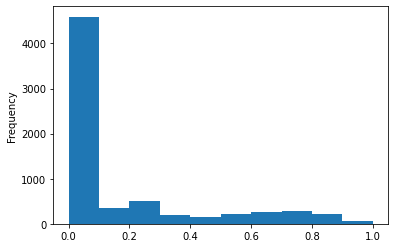

In [7]:
import pandas as pd
from nltk import edit_distance

pcd_mapped = pd.DataFrame({
    'ks': ks, 
    'titles1': titles1, 
    'titles2': titles2,
    'ed': [edit_distance(x1, x2) / len(x2) for x1, x2 in zip(titles1, titles2)],
    'doi': doi,
})
k2doi = {x['ks']: x['doi'] for i, x in pcd_mapped.iterrows()}
pcd_mapped.ed.plot(kind='hist', range=(0, 1))

In [38]:
import pickle
dmm_data = pickle.load(open('intermediate_data/DMM_TrainingData.pypickle', 'rb'))
pcd_data_prefiltering = pickle.load(open('intermediate_data/PCD_TrainingData_prefiltering.pypickle', 'rb'))

In [39]:
duplicates = set(dmm_data.meta_doi) & set(pcd_mapped.doi.values.tolist())
len(dmm_data), len(pcd_data_prefiltering), len(duplicates)

(7562, 7677, 181)

In [40]:
pcd_data = pcd_data_prefiltering.copy()
pcd_data['meta_doi'] = pcd_data['meta_k'].apply(lambda x: k2doi.get(x, 'N/A'))
pcd_data = pcd_data.loc[pcd_data.meta_doi.apply(lambda x: x not in duplicates)]
len(pcd_data)

7227

In [41]:
with open('intermediate_data/PCD_TrainingData.pypickle', 'wb') as f:
    pickle.dump(pcd_data, f)